Carlos Garcia - 21000475

### Librerías

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn import tree

In [2]:
from auxiliaryFunctions import getMetrics, writeModelResults, readModels, getModelPredictions, get_topModels, ensemblePredictions, ensembleMetrics

Instructions for updating:
non-resource variables are not supported in the long term


### Cargar modelos elegidos

In [3]:
data = pd.read_csv('./input/data_titanic_proyecto.csv')
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [4]:
results = pd.read_csv('./results/model_results.csv')
results['model_type'] = results['model'].apply(lambda row: row.split('_', 1)[0])
results.head()

,model,accuracy,error,precision,recall,f1-score,model_type
0,decisionTree_criterion=entropy_depth=None_mins...,0.8042,0.1958,0.7358,0.7358,0.7358,decisionTree
1,decisionTree_criterion=entropy_depth=10_minspl...,0.8112,0.1888,0.7708,0.6981,0.7327,decisionTree
2,decisionTree_criterion=gini_depth=10_minsplit=...,0.7972,0.2028,0.7308,0.7170,0.7238,decisionTree
3,SVM_C=1_kernel=rbf__SibSp_Parch_Fare_passenger...,0.7832,0.2168,0.9231,0.4528,0.6076,SVM
4,SVM_C=2_kernel=rbf__SibSp_Parch_Fare_passenger...,0.8252,0.1748,0.8684,0.6226,0.7253,SVM


In [5]:
top_models = get_topModels(results)
top_models

,model,accuracy,error,precision,recall,f1-score
model_type,,,,,,
NaiveBayes,NaiveBayes__SibSp_Parch_Fare_passenger_class_i...,0.8112,0.1888,0.7407,0.7547,0.7477
SVM,SVM_C=4_kernel=rbf__SibSp_Parch_Fare_passenger...,0.8322,0.1678,0.8222,0.6981,0.7551
decisionTree,decisionTree_criterion=entropy_depth=10_minspl...,0.8112,0.1888,0.7708,0.6981,0.7327
regLog,regLog_lr=0.01_reg=l2_lambda=0.001_mbatch=20_e...,0.8112,0.1888,0.7600,0.7170,0.7379


In [6]:
models = dict()
for index, row in top_models.iterrows():
    model = readModels(row['model'], index)
    models[index] = model

In [7]:
models.keys()

dict_keys(['NaiveBayes', 'SVM', 'decisionTree', 'regLog'])

### Datos de prueba

In [8]:
data = pd.read_csv('./input/data_titanic_proyecto.csv')
data.dropna(axis = 1, how = 'any', inplace = True)

In [9]:
enc = OrdinalEncoder()
pclass = np.sort(data.passenger_class.unique())
pclass = np.expand_dims(pclass, axis = 1)
enc.fit(pclass)

data['passenger_class'] = enc.transform(data[['passenger_class']])

In [10]:
data['isFemale'] = np.where(data['passenger_sex'] == 'F', 1, 0)
data.drop(['PassengerId', 'Name', 'Ticket', 'passenger_sex', 'passenger_survived'], axis = 1, inplace = True)

In [11]:
scaler = MinMaxScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1].values)
data = data.sample(n = 10, random_state = 202).copy().reset_index(drop = True)
data.head(10)

,SibSp,Parch,Fare,passenger_class,isFemale
0,0.000,0.000000,0.028221,0.0,1
1,0.000,0.500000,0.037590,0.0,1
2,0.250,0.333333,0.512122,1.0,1
3,0.500,0.333333,0.061264,0.0,1
4,0.000,0.000000,0.016908,0.0,0
5,0.000,0.000000,0.014151,0.0,0
6,0.000,0.000000,0.015713,0.0,0
7,0.000,0.333333,0.029758,0.0,1
8,0.125,0.000000,0.103644,1.0,1
9,0.000,0.000000,0.028302,0.0,0


### Predicción

In [12]:
def simulatePrediction(models, x_predict):

    #Get all models predictions
    predictions = dict()
    for model_name, model  in models.items():
        predictions[model_name] = getModelPredictions(model, x_predict, model_type = model_name)
   
    #Get NaiveBayes and RegLog probs
    probs = dict()
    probs['NaiveBayes'] = getModelPredictions(models['NaiveBayes'], x_predict, model_type = 'NaiveBayes', return_probs = True)
    prl = getModelPredictions(models['regLog'], x_predict, model_type = 'regLog', return_probs = True)
    probs['regLog'] = np.array([1-prl, prl], ndmin = 2)

    #Define the mode of the class predicted
    preds = np.array(list(predictions.values()))
    means = np.mean(preds, axis = 0)
    mode = np.round(means)
    mode = mode.astype(int)
    mode = 'Survived' if mode[0] == 1 else 'Not Survived'

    return mode, probs

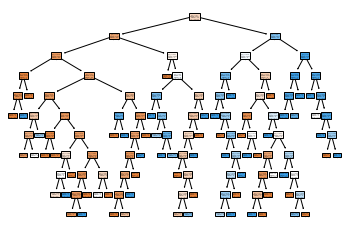

In [13]:
tree_graph = tree.plot_tree(models['decisionTree'], filled = True)

In [14]:
for i in range(0,len(data)):
    prediction, probabilities = simulatePrediction(models, data.loc[[i]])
    print("Iteración {}------------".format(i+1))
    print('Predicción combinada: ', prediction)
    print('NaiveBayes probs: N={}  Y={}'.format(probabilities['NaiveBayes'][0,0], probabilities['NaiveBayes'][0,1]))
    print('RegLog probs: N={}  Y={}'.format(probabilities['regLog'][0,0], probabilities['regLog'][0,1]))
    print('\n')

Iteración 1------------
Predicción combinada:  Survived
NaiveBayes probs: N=1.647912038626922  Y=1.8813679997276394
RegLog probs: N=0.3966619372367859  Y=0.6033380627632141


Iteración 2------------
Predicción combinada:  Survived
NaiveBayes probs: N=0.01753613571764626  Y=0.10866653688373272
RegLog probs: N=0.3960586190223694  Y=0.6039413809776306


Iteración 3------------
Predicción combinada:  Survived
NaiveBayes probs: N=7.175478860990359e-15  Y=0.0021790808445698658
RegLog probs: N=0.1705634593963623  Y=0.8294365406036377


Iteración 4------------
Predicción combinada:  Not Survived
NaiveBayes probs: N=0.00390032453678103  Y=8.093976054662816e-05
RegLog probs: N=0.4193803668022156  Y=0.5806196331977844


Iteración 5------------
Predicción combinada:  Not Survived
NaiveBayes probs: N=20.567726409572458  Y=0.7562744112945969
RegLog probs: N=0.7813318967819214  Y=0.2186681032180786


Iteración 6------------
Predicción combinada:  Not Survived
NaiveBayes probs: N=20.187030281152026  Y